In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

### Quelle der Daten: 
https://www.bundestag.de/services/opendata

### Erläuterungen
WP steht für Wahlperiode

In [2]:
DATA_PATH = Path('data')
MDB_XML_PATH = DATA_PATH / 'MDB_STAMMDATEN.XML'
DF_MDB_PATH = DATA_PATH / 'df_mdb.csv' #one row per individuum, one col per wp containing 0 / 1
DF_MDB_WP_PATH = DATA_PATH / 'df_mdb_wp.csv' # one row per individuum per wp, containting e.g. 12. so one abgeordneter who has been in parliament for several wp will receive one row per wp

# parse xml data into dataFrame / .csv fomat

In [3]:
def get_mdb_data(mdb_xml_path = MDB_XML_PATH):
    """get data frame of MDP data
    ID | NACHNAME | VORNAME |  ... | BERUF"""
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            mdb_dict[int(wahlperiode.find('WP').text)] = 1

        list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)

In [4]:
def get_mdb_wp_data(df_mdb):
    """
    reformat
    peter | lustig | wp1 | wp2
    
    into
    peter | lustig | wp1
    peter | lustig | wp2
    """
    
    wps = [column for column in df_mdb.columns if isinstance(column, int)] # probably 1 to 19 or 20
    columns_to_keep = [column for column in df_mdb.columns if not isinstance(column, int)] # 'BERUF', 'VITA_KURZ' etc
    
    # should be 19 before 2021, 20 afterwards
    max_wp = max(wps)
    
    # this could be optimized but only runs once for about 2 Minutes
    new_entries = []
    for idx, row in df_mdb.iterrows():
        for wp in wps:
            if row[wp] == 1:
                new_entry = row[columns_to_keep]
                new_entry['WP'] = wp
                new_entries.append(new_entry)
    
    mdb_wp = pd.DataFrame(new_entries)
    return(mdb_wp)

In [5]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [6]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

# compute Age

In [7]:
df_mdb['GEBURSDATUM_DATE'] = pd.to_datetime(df_mdb.GEBURTSDATUM)

In [8]:
df_mdb.head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,12,13,14,15,16,1,17,18,19,GEBURSDATUM_DATE
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1930-10-20
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909-09-04
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1913-05-26
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1933-06-11
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1950-09-06


In [9]:
wp_startdaten = {
    1:datetime(1949, 9, 7), # Der 1. Deutsche Bundestag bestand zwischen dem 7. September 1949[1] und dem 7. September 1953
    2:datetime(1953, 10, 6), # Der 2. Deutsche Bundestag bestand zwischen dem 6. Oktober 1953[1] und dem 6. Oktober 1957
    3:datetime(1957, 10, 15), # Der 3. Deutsche Bundestag bestand zwischen dem 15. Oktober 1957[1] und dem 15. Oktober 1961
    4:datetime(1961, 10, 17), # Der 4. Deutsche Bundestag bestand zwischen dem 17. Oktober 1961[1] und dem 17. Oktober 196
    5:datetime(1965, 10, 19), # Der 5. Deutsche Bundestag bestand zwischen dem 19. Oktober 1965[1] und dem 19. Oktober 1969
    6:datetime(1969, 10, 20), # Der 6. Deutsche Bundestag bestand zwischen dem 20. Oktober 1969[1] und dem 13. Dezember 1972
    7:datetime(1972, 12, 13), #? Der 7. Deutsche Bundestag wurde am 19. November 1972 gewählt
    8:datetime(1976, 12, 14), # Der 8. Deutsche Bundestag bestand zwischen dem 14. Dezember 1976[1] und dem 4. November 1980
    9:datetime(1980, 11, 4),# Der 9. Deutsche Bundestag bestand zwischen dem 4. November 1980[1] und dem 29. März 1983
    10:datetime(1983, 3, 29), # Der 10. Deutsche Bundestag bestand zwischen dem 29. März 1983[1] und dem 18. Februar 1987
    11:datetime(1987, 2, 18), # Der 11. Deutsche Bundestag bestand zwischen dem 18. Februar 1987[1] und dem 20. Dezember 1990
    12:datetime(1990, 12, 20), # Der 12. Deutsche Bundestag bestand zwischen dem 20. Dezember 1990[1] und dem 10. November 1994
    13:datetime(1994, 11, 10), # Der 13. Deutsche Bundestag bestand zwischen dem 10. November 1994[1] und dem 26. Oktober 1998
    14:datetime(1998, 10, 26), # Der 14. Deutsche Bundestag bestand zwischen dem 26. Oktober 1998[1] und dem 17. Oktober 2002
    15:datetime(2002, 10, 17), # Der 15. Deutsche Bundestag bestand zwischen dem 17. Oktober 2002[1] und dem 18. Oktober 2005
    16:datetime(2005, 10, 18), # Der 16. Deutsche Bundestag bestand zwischen dem 18. Oktober 2005[1] und dem 27. Oktober 2009
    17:datetime(2009, 10, 27), # Der 17. Deutsche Bundestag bestand zwischen dem 27. Oktober 2009[1] und dem 22. Oktober 2013
    18:datetime(2013, 10, 22), # Der 18. Deutsche Bundestag bestand vom 22. Oktober 2013 bis zum 24. Oktober 2017
    19:datetime(2017, 10, 24) #  Seine konstituierende Sitzung fand am 24. Oktober 2017 statt,
}

df_wp_startdaten=pd.DataFrame(wp_startdaten, index=[0]).T
df_wp_startdaten.columns =[ 'START_DATE']
print(df_wp_startdaten.head())
df_wp_startdaten.to_csv('data/wp_startdaten.csv')

  START_DATE
1 1949-09-07
2 1953-10-06
3 1957-10-15
4 1961-10-17
5 1965-10-19


## Insight: es werden immer mehr Abgeordnete

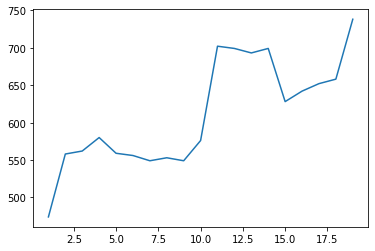

In [10]:
wps = [column for column in df_mdb.columns if isinstance(column, int)]
fig, ax = plt.subplots()#plt.figure(figsize=(8,6))

# xlab / ylab not showing is nb issue
plt.xlabel='WP'
plt.ylabel='Anzahl Abgeordneter'
#plt.plot(df_mdb[wps].sum().sort_index())
df_mdb[wps].sum().sort_index().plot()
plt.show()

In [11]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [12]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

In [13]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock'].iloc[0].VITA_KURZ)

('2000/04 Studium der Politikwissenschaft und Öffentliches Recht in Hamburg; '
 '2000/03 freie Mitarbeit bei der Hannoverschen Allgemeinen Zeitung; 2005 '
 'Master im Völkerrecht (LL.M.) an der LSE London; 2005/08 Büroleiterin der '
 'Europaabgeordneten Elisabeth Schroedter in Brüssel und Potsdam. 2008/09 '
 'Referentin für Außen- und Sicherheitspolitik bei der Grünen '
 'Bundestagsfraktion. 2009/13 Landesvors. BÜNDNIS 90/DIE GRÜNEN Brandenburg. '
 'Seit 2005 Mitgl. von Bündnis 90/Die Grünen, 2009/12 Mitgl. im Vorstand der '
 'Europäischen Grünen Partei; 2012/15 Mitgl. im Parteirat von Bündnis 90/Die '
 'Grünen, seit Jan. 2018 Bundesvors. von Bündnis90/Die Grünen. Englisch (f), '
 'Französisch (G), Spanisch (G). - MdB seit Okt. 2013.')


# clean data 1. missing values

In [14]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [15]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replace values: PARTEI_KURZ

In [16]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [17]:
# some cleaning necessary: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90' => 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

# replace values: RELIGION

In [18]:
df_mdb['RELIGION_MAPPED'] = df_mdb['RELIGION']
df_mdb.RELIGION_MAPPED.value_counts().head(12)

ohne Angaben              1214
evangelisch               1154
katholisch                 870
römisch-katholisch         316
UNBEKANNT                  227
evangelisch-lutherisch     138
konfessionslos             118
evangelisch-reformiert      15
religionslos                 7
Atheistin                    6
muslimisch                   5
freireligiös                 3
Name: RELIGION_MAPPED, dtype: int64

In [19]:
for katholisch_alias in ['römisch-katholisch', 'alt-katholisch']:
    df_mdb['RELIGION_MAPPED'].replace(katholisch_alias, 'katholisch', inplace=True)

In [20]:
for evangelisch_alias in ['evangelisch-lutherisch', 'evangelisch-reformiert', 'evangelisch-freikirchlich', 'protestantisch']:
    df_mdb['RELIGION_MAPPED'].replace(evangelisch_alias, 'evangelisch', inplace=True)

In [21]:
# it's not the same but its similar
for konfessionslos_alias in ['religionslos', 'Atheist', 'Atheistin']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'konfessionslos', inplace=True)

In [22]:
for konfessionslos_alias in ['Islam']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'muslimisch', inplace=True)

In [23]:
# erkenntnis: nur christen und einige wenige konfessionslose
df_mdb['RELIGION_MAPPED'].value_counts().head(24)

evangelisch            1311
ohne Angaben           1214
katholisch             1187
UNBEKANNT               227
konfessionslos          133
muslimisch                8
freireligiös              3
russisch-orthodox         1
orthodox                  1
neuapostolisch            1
alevitisch                1
humanistisch              1
griechisch-orthodox       1
Name: RELIGION_MAPPED, dtype: int64

<AxesSubplot:>

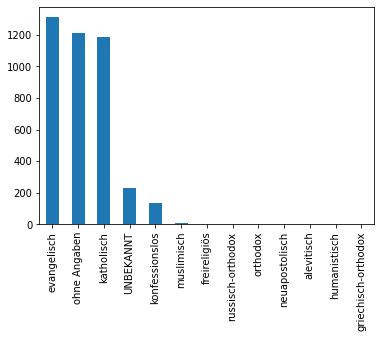

In [24]:
df_mdb['RELIGION_MAPPED'].value_counts().plot(kind='bar')

# replace values: FAMILIENSTAND

In [25]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb['FAMILIENSTAND_MAPPED'] = df_mdb['FAMILIENSTAND']
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('verheiratet', 'verh.'))
df_mdb.FAMILIENSTAND_MAPPED= df_mdb.FAMILIENSTAND_MAPPED.apply(lambda x: x.replace('geschieden', 'gesch.'))
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., 4 Kinder",251
ledig,202
"verh., 5 Kinder",98
UNBEKANNT,81


In [26]:
indikator = re.compile('^verh.,\s([4-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'verh., >3 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'verh., 6 Kinder', 'verh., 7 Kinder', 'verh., 9 Kinder', 'verh., 12 Kinder', 'verh., 8 Kinder', 'verh., 10 Kinder', 'verh., 4 Kinder', 'verh., 5 Kinder'}


/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [27]:
indikator = re.compile('^gesch.,\s([1-9] |\d{2,}) *Kind')
values_to_replace = set(df_mdb[df_mdb.FAMILIENSTAND_MAPPED.str.contains(indikator)].FAMILIENSTAND_MAPPED)
print(values_to_replace)
replace_value = 'gesch., >0 Kinder'
df_mdb['FAMILIENSTAND_MAPPED'].replace(values_to_replace, replace_value, inplace=True)

{'gesch., 2 Kinder', 'gesch., 3 Kinder', 'gesch., 5 Kinder', 'gesch., 4 Kinder', 'gesch., 1 Kind'}


In [28]:
df_mdb[['ID', 'FAMILIENSTAND_MAPPED']].groupby('FAMILIENSTAND_MAPPED').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND_MAPPED,
"verh., 2 Kinder",932
verh.,565
"verh., 3 Kinder",550
keine Angaben,540
"verh., 1 Kind",465
"verh., >3 Kinder",422
ledig,202
UNBEKANNT,81
"gesch., >0 Kinder",80


# replace values: BERUFE

In [29]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [30]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [31]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47
Kaufmann,45
Journalist,43
Hausfrau,41


In [32]:
from importlib import reload
import src.berufe_mapping as berufe_mapping
reload(berufe_mapping)
from berufe_mapping import basic_cleaning_berufe

'''very basic cleaning: lowercasing, removing dipl., (fh) and a.d.'''
df_mdb = basic_cleaning_berufe(df_mdb , column = 'BERUF_MAPPED')

In [33]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF_MAPPED,
rechtsanwalt,373
geschäftsführer,111
landwirt,105
-ingenieur,101
-volkswirt,82
lehrer,75
jurist,73
angestellter,73


In [34]:
re.sub('regierungs(vize)*präs', 'XX', 'abc regierungspräsident xjsk regierungsvizepräsidentin')

'abc XXident xjsk XXidentin'

In [35]:
dict_berufe={}
dict_berufe['Jurist*in'] = ['anwalt', 'jurist', 'richter', 'notar', re.compile('dr.*\s*jur.*'), 'syndikus', 'rechtsberater']
dict_berufe['Land-/Forstwirt*in'] = ['landwirt', '^[a-z]bauer\s', 'bauer', re.compile('agrar+'), 'forst']
dict_berufe['Unterehmer*in'] = ['unternehmer'] # geschäftsführer geht leider nicht wegen z.B. Parl. Geschäftssführer
dict_berufe['Ingenieur*in'] = ['ingenieur', 'maschinenbau', 'architekt']
dict_berufe['Journalist*in'] = ['journalist', 'redakteur', 'publizist', 'schriftsteller']
dict_berufe['Verleger*in'] = ['verleger', 'verlags']

# direktor: nö, sonst bezirksdirektor museumsdirektor etc
dict_berufe['Lehrer*in'] = ['erzieher', 'pädagog', 'lehrer', 'studienrat', 'studiendirektor', 'schulrat',
                            'grundschul', 'hauptshul', 'sonderschul', 'waldorf', 'realschul', 'gymnasi',
                            'volkshochschu', 'berufsschul', 'fremdsprachen',
                           'schul'] #evtl trennen Erzieher - Lehrer
dict_berufe['Professor*in'] = ['dozent', 'professor', 'prof.', 'hochschull', 'hochschulpr']
dict_berufe['Kaufmann/-frau'] = ['kaufm']
dict_berufe['Volkswirt*in'] = ['volkswirt']
dict_berufe['Berufspolitiker*in'] = ['regierungsangestellt', 'stadtamtmann', 'stadtoberinspektor', 'Landesgeschäftsführer',
                                    'landr(at|ätin)', re.compile('ministerialr(a|ä)t'), 'staatssekret', 'bürgermeist', 
                                     'regierungsrat', re.compile('regierungs(vize)*präs'), 'regierung',
                                     'stadtdirektor', 'ministerialdirektor', 'regierungsdirektor', 'gemeindedirektor', 'regierungsdirektor',
                                     'minister', 'bundeskanz', 'bundestagsp', re.compile('präsident(in)* d\.*b\.*t\.*')]
dict_berufe['Arzt/Ärztin'] = ['arzt', 'psycholog', 'psychother', 'apotheker']
dict_berufe['Theolog*in'] = ['pfarrer', 'theolog', 'diakon']
dict_berufe['Betriebswirt*in'] = ['betriebswirt', 'verwaltungs', 'steuerberater', 'bankdirektor']
dict_berufe['Wirtschaftswissenschaftler*in'] = ['wirtschaftsw', 'ökonom', 'prokurist']
dict_berufe['Geisteswissenschaftler*in'] = ['politolog', 'politikwiss', 'historik', 'philosoph', 'philolog', 'soziolog', 'sozialwissensch', 'kulturwissenschaft']
dict_berufe['Naturwissenschaftler*in'] = ['chemik', 'chemie', 'physik', 'geophysik', 'biolog', 'mathemat', 'informat']

dict_berufe['Handwerker*in'] = ['elektro', 'fahrzeug', 'handwerk', 'mechanik',
                               'schlosser', 'maurer', 'beton', 'maler', 'lackier', 'tischler', 'schreiner',
                               'bäcker', 'konditor' 'koch', 'köchin', 'müller', 'bergmann', 'werkzeugmacher']
dict_berufe['Militär'] = ['leutnant', 'oberst^u', 'soldat', re.compile('general\s')] # not oberstudienrat ;)
dict_berufe['Beamter'] = ['beamter']# problematisch: Berufspolitiker, Lehrer, Militär sind auch beamte

In [36]:
re.sub('oberst[^u]', 'X', 'oberst oberst oberst')

'XXoberst'

In [37]:
def replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb):
    values_to_replace = set()
    # TODO without loop but use 'any'
    for indikator in dict_berufe[berufsklasse]:
        values_to_replace = values_to_replace.union(set(df_mdb[df_mdb.BERUF_MAPPED.str.contains(indikator)].BERUF_MAPPED))

    print(values_to_replace)
    df_mdb.replace(list(values_to_replace), berufsklasse, inplace=True)
    return(df_mdb)

In [38]:
df_mdb = replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb)

{'richter', 'rechtsanwalt f. steuerrecht', 'volljurist', 'rechtsanwalt', 'rechtsanwaltsgehilf', 'handelskammersyndikus', 'syndikusanwalt', 'richterin', 'richter am landgericht', 'handwerkskammersyndikus', 'richterin am landgericht', 'richter am oberlandesgericht', 'richterin am kammergericht', 'richterin i. r.', 'richter am bundesgerichtshof', 'jurist (richter)', 'notar', 'wirtschaftsjurist', 'rechtsanwalt u. notar', 'richterin a. lg.', 'richterin am amtsgericht', 'rechtsanwalts-', 'staatsanwalt', '-jurist', 'richter am oberverwaltungsgericht', 'jurist', 'rechtsanwalt (tätigkeit ruhend)', 'verwaltungsjurist', 'steuerjurist', 'vorsitzender richter am landgericht', 'oberstaatsanwalt', 'rechtsberater', 'familienrichterin', 'rechtanwalt', 'höherer dienst bund/land (ministerialrat); landrat; rechtsanwalt', 'richter i. r.', 'oberamtsrichter', 'dr. jur.', 'syndikus', 'generalbundesanwalt'}


In [39]:
df_mdb = replace_berufsklasse(berufsklasse = 'Land-/Forstwirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'stahlbetonbauer', '-landwirt', 'landwirtschaftsmeister', 'selbstständiger landwirt', 'schiffbauer', 'maschinenbauer', 'land- u. forstwirt', 'hochschulagraringenieur', 'austragbauer', 'forstmeister i. r.', '-agraringenieur', 'oberlandwirtschaftsrat', 'straßenbauer', 'forstoberrat', '-forstingenieur', 'agraringenieur', '-agraringenieurin', '-forstwirt', 'agrarreferent', 'landwirt', 'landwirtschaftsdirektorin', 'betonbauer', 'bauer', 'oberregierungslandwirtschaftsrat', 'agrarwissenschaftler', 'forstwirt', 'landwirtschaftsrat'}


In [40]:
df_mdb = replace_berufsklasse(berufsklasse = 'Unterehmer*in', dict_berufe = dict_berufe, df = df_mdb)

{'selbstständiger unternehmer', 'transportunternehmer', 'speditionsunternehmer', 'unternehmer', 'selbst. unternehmer', 'bauunternehmer', 'handwerksunternehmer', 'selbständiger unternehmer'}


In [41]:
df_mdb = replace_berufsklasse(berufsklasse = 'Ingenieur*in', dict_berufe = dict_berufe, df = df_mdb)

{'architekt', 'bauingenieur', 'oberingenieur', '-wirtschaftsingenieur', 'betriebsingenieur', '-wirtschaftsingenieurin', '-ingenieurökonom', 'maschinenbauingenieur', '-ingenieurin  lebensmittelkonservierer', 'bergingenieur', 'textilingenieur', 'elektroingenieur', 'hochschulingenieur', 'bauingenieur (gr', '-meliorationsingenieur', '-ingenieurin  fb architektur', 'wirtschaftsingenieur', 'ingenieurökonom', 'vertriebsingenieur', '-elektroingenieur', '-ing.  architekt', '-ingenieurin', 'gartenarchitekt', '-innenarchitekt', 'freie innenarchitekt', '-bauingenieur', 'maschinenbaumeister', 'ingenieur (gr', 'chemieingenieur', 'ingenieur', 'architekt bda', 'öffentlich bestellter vermessungsingenieur', '-ingenieur', '-ingenieur (tu)', '-maschinenbauingenieur', '-chemieingenieur'}


In [42]:
len(set(df_mdb.BERUF_MAPPED))

1001

In [43]:
df_mdb = replace_berufsklasse(berufsklasse = 'Journalist*in', dict_berufe = dict_berufe, df = df_mdb)

{'freie journalist', 'journalist', 'fernsehjournalist', 'freier journalist', 'chefredakteur', 'wissenschaftlicher redakteur', 'publizist', 'schriftsteller', 'politischer redakteur', 'freiberufliche redakteur', 'pr-journalist', 'redakteur', 'rundfunk-redakteur'}


In [44]:
df_mdb = replace_berufsklasse(berufsklasse = 'Lehrer*in', dict_berufe = dict_berufe, df = df_mdb)

{'oberschulrat', 'lehrer am gymnasium (oberstudienrat)', 'schulamtsdirektor', 'stellvertr. schulleiter', 'lehrerin im hochschuldienst', 'gymnasiallehrer', 'pädagogin m a', 'fachschullehrer', 'schulleiterin', 'grund - u. hauptschullehrer', 'lehrerin', 'professor an einer wissenschaftlichen hochschule', 'lehrerin (strin)', 'realschuldirektor', 'realschullehrer', 'sonderschulpädagog', 'studiendirektorin', 'fachhochschullehrer', '-medizinpädagoge', 'studiendirektor', 'schulrat', 'pädagogischer leiter', '-lehrer', 'gewerbeschullehrer', 'regierungs- u.schulrat z. wv.', 'fachhochschulprofessor', 'sttschuldirektor', 'oberlehrer', 'pädagogische mitarbeiter', 'leitender gesamtschuldirektor', 'pädagoge', 'krankenvertretung staatlicher schuldienst', 'hochschullehrer', 'erzieher', 'hauptschulrat', 'hochschuldozent', 'volkshochschuldirektor', 'schulamtsleiter', '-sozialpädagoge', 'volksschulrektor', 'technischer lehrer', 'volkshochschulangestellter', 'realschulektorin', '-pädagoge', '-lehrer biologi

In [45]:
df_mdb = replace_berufsklasse(berufsklasse = 'Kaufmann/-frau', dict_berufe = dict_berufe, df = df_mdb)

{'technischer kaufmann', 'bürokaufmann', 'reiseverkehrskaufmann', 'schifffahrtskaufmann', 'textilkaufmann', 'verlagskaufmann', 'kaufmann', 'hotelkaufmann', 'datenverarbeitungskaufmann', 'grundstücks- u. wohnungswirtschaftskaufmann', 'versichrungskaufmann', 'kaufm. angestellte', 'immobilienkaufmann', 'bankkaufmann', 'mineralölkaufmann', 'kaufmännische angestellte', 'viehkaufmann', 'selbständiger einzelhandelskaufmann', '-kaufmann (univ.)', 'reisebürokaufmann', 'wirtschaftskaufmann', 'versicherungskaufmann', 'baukaufmann', 'kaufmann im einzelhandel', 'kaufmännische angest.', 'selbständiger kaufmann', 'speditionskaufmann', 'selbstständige industriekaufmann', 'außenhandelskaufmann', '-kaufmann', 'selbstständiger kaufmann', '-kaufmann wp/stb', 'selbst. kaufmann', 'großhandelskaufmann', 'industriekaufmann', 'kaufmännischer angestellter', 'kaufmännischer direktor', 'pharmazeutisch kaufmännische assistent', 'werbekaufmann', 'kaufm.angestellter', 'einzelhandelskaufmann'}


In [46]:
df_mdb = replace_berufsklasse(berufsklasse = 'Professor*in', dict_berufe = dict_berufe, df = df_mdb)

{'studienprofessor', 'honorarprofessor', 'universitätsprofessor der rechte', 'ordentlicher professor', 'universitätsprofessor', 'professor der betriebswirtschaft', 'prof.', 'o. professor', 'o. universitätsprofessor', 'ordentlicher universitätsprofessor', 'professor', 'dozent'}


In [47]:
len(set(df_mdb.BERUF_MAPPED))

844

In [48]:
df_mdb = replace_berufsklasse(berufsklasse = 'Volkswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'volkswirt (gr', 'volkswirt', '-volkswirt (uni)', '-volkswirt', 'technischer -volkswirt', '-volkswirt (universität)', 'volkswirtschaftler'}


In [49]:
df_mdb = replace_berufsklasse(berufsklasse = 'Berufspolitiker*in', dict_berufe = dict_berufe, df = df_mdb)

{'oberregierungsrat  bundesminister', 'präsidentin dbt', 'bundestagspräsident', 'staatsmister beim bundesminister der auswärtigen', 'regierungsassessor', 'ministerialdirigent', 'bundesminister des innern', 'bundeskanzler', 'präsident dbt', 'staatsministerin', 'oberbürgermeisterin', 'ministerialdirektor z. d.', 'landrat', 'staatssekretär i. r.', 'vizepräsident dbt', 'leitender regierungsdirektor', 'staatsminister', 'bürgermeisterin', 'bezirksbürgermeister', '1. bürgermeister', 'bundesminister des auswärtigen', 'regierungsangestellter', 'regierungsangestellte', 'regierungsrät', 'regierungspräsident', 'wirtschaftsminister u. stellvertr. ministerpräsident', 'referentin landesministerium nrw', '-betriebswirt  bürgermeister', 'ministerialdirektor i. r.', 'amtsbürgermeister', 'oberbürgermeister', 'regierungsvizepräsident', 'regierungsinspektor', 'regierungsrat', 'bundesministerin', 'regierungsdirektor', 'staatsminister im auswärtigen amt', 'regierungspräsident z. d.', 'regierungsdirektorin', 

/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [50]:
df_mdb = replace_berufsklasse(berufsklasse = 'Arzt/Ärztin', dict_berufe = dict_berufe, df = df_mdb)

{'-psychologe', 'chefarzt im bezirkskrankenhaus schwer', 'werksarzt', 'mannenarzt', 'arzt allgemein/ tropenmediz', 'apotheker', 'arzt', 'zahnarzt', 'kinderarzt', 'psycholog', 'facharzt', '-psycholog', 'fachpsychologin der mediz', 'tierarzt', 'beratender psychologe', 'praktischer arzt'}


In [51]:
df_mdb = replace_berufsklasse(berufsklasse = 'Theolog*in', dict_berufe = dict_berufe, df = df_mdb)

{'diakon', 'pfarrer i. r.', 'pfarrer', '-theologe', 'theolog', 'theologe', 'pfarrer im wartestand'}


In [52]:
df_mdb = replace_berufsklasse(berufsklasse = 'Betriebswirt*in', dict_berufe = dict_berufe, df = df_mdb)

{'verwaltungswirt', 'sparkassenbetriebswirt', '-verwaltungswirtin', 'verwaltungsfachangestellter', 'verwaltungsfachwirt', 'kreisverwaltungsdirektor', '-betriebswirtin', 'verwaltungsvollzugsbeamter', '-bankbetriebswirt (fs)', 'städtischer ltd. verwaltungsdirektor', 'selbständige steuerberater', 'verwaltungsbeamter', 'betriebswirt', 'sttverwaltungsrat', 'verwaltungsangestellter', 'bundesbankdirektor', '-betriebswirtschaftler', 'steuerberater', 'verwaltungsamtsrat', 'verwaltungsangestellte', 'kreisverwaltungsreferent', '-betriebswirtin  amtmann', 'verwaltungsamtmann', 'betriebswirtin (vwa)', 'verwaltungsamtmann (sachbearbeiter)', 'verwaltungsrat', '-verwaltungswirt', '-verwaltungswissenschaftler', 'bankdirektor', 'betriebswirtin sgd', 'landesoberverwaltungsrat', 'rechtskundige verwaltungsdirektorin', 'verwaltungsratsvorsitzender', 'verwaltungsoberinspektor', 'verwaltungsdirektor', 'verwaltungsleiter', 'verwaltungs-', '-betriebswirt', 'verwaltungs-betriebswirtin (vwa)', '-verwaltungswirt p

In [53]:
df_mdb = replace_berufsklasse(berufsklasse = 'Wirtschaftswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'ing.-ökonom', 'prokurist', 'ökonom', '-ökonom', '-sozialökonom', 'wirtschaftswissenschaftler', 'ökonomierat', 'personalmanagementökonomin (vwa)'}


In [54]:
df_mdb = replace_berufsklasse(berufsklasse = 'Geisteswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'-soziologe', 'kulturwissenschaftler', 'politologe', 'politikwissenschaftler (m.a.)', 'philologe', '-politikwissenschaftler', '-politologe', 'politikwissenschaftler (m. a.)', 'politolog', '-politolog', 'politikwissenschaftler ma', '-sozialwissenschaftler', 'philolog', 'soziolog', '-philosoph', 'soziologe', '- politolog', 'politikwissenschaftliche doktorand', 'sozialwissenschaftler', '-historiker', 'historiker', 'kunsthistoriker', 'politikwissenschaftler m. a.', 'literaturhistoriker', 'klassischer philologe', 'politikwissenschaftler', '-soziolog'}


In [55]:
df_mdb = replace_berufsklasse(berufsklasse = 'Naturwissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'-mathematiker', '-chemiker', 'biologe', 'physikochemiker', 'biolog', 'chemiker', 'chemielaborant', 'physiker', '-biologe', '-physiker', 'informatiker', 'mikrobiologe', 'physikalisch-technische assistent', '-biolog', 'staatlich geprüfte informatiker', '-informatiker', '-geophysiker', 'chemiefacharbeiter', 'wirtschaftsinformatiker', 'biologiestudent', 'biochemiker', 'mathematiker'}


In [56]:
df_mdb = replace_berufsklasse(berufsklasse = 'Verleger*in', dict_berufe = dict_berufe, df = df_mdb)

{'selbst. verlagsrepräsentant', 'verleger', 'verlagsgeschäftsführer', 'verlagsleiter', 'zeitungsverleger'}


In [57]:
df_mdb = replace_berufsklasse(berufsklasse = 'Handwerker*in', dict_berufe = dict_berufe, df = df_mdb)

{'elektromeister', 'selbstständiger bäckermeister', 'bäckerm.', 'betonfacharbeiter', 'schreiner', 'elektro.-ing.', 'schlosser', 'elektromeister in der energiewirtschaft', 'elektroniker', 'tischlermeister', 'geschäftsführer der handwerkskammer ostthüringen', 'mechaniker', 'werkzeugmacher', 'meister des maler-', 'schreinermeister', 'kfz.-mechaniker', 'bäckermeister', 'keramikmaler', 'feinmechaniker', 'maschinenschlosser', 'elektro-techniker', 'malermeister', 'maurer', 'bergmann (hauer)', 'meister im maurer-', 'industriemechaniker', 'tischlergeselle', 'bergmann', 'elektrohandwerksmeister', 'kraftfahrzeughandwerker', 'schlosservorarbeiter', 'modellschreiner', 'selbständiger kfz.-mechanikermeister', 'bäcker', 'elektroinstallateur', 'handwerksmeister', 'müllermeister', 'elektromechaniker', 'bäcker- u. konditormeister', 'elektrotechniker', '-ing. elektrotechnik', 'tischlergesell', 'funkmechaniker', 'elektromonteur', 'mechanikermeister', 'elektroschweißer'}


In [58]:
df_mdb = replace_berufsklasse(berufsklasse = 'Militär', dict_berufe = dict_berufe, df = df_mdb)

{'soldat', 'berufssoldat', 'oberstleutnant'}


In [59]:
df_mdb = replace_berufsklasse(berufsklasse = 'Beamter', dict_berufe = dict_berufe, df = df_mdb)

{'kommunalbeamter', 'kriminalpolizeibeamter', 'postbeamter', 'eisenbahnbeamter', 'beamter (amtsrat); persönl. referent', 'kriminalbeamter', 'bundesbahnbeamter', 'steuerbeamter', 'beamter i. r.', 'fernmeldebeamter', 'feuerwehrbeamter', 'beamter', 'beamter i. s. b.', 'finanzbeamter', 'polizeibeamter', 'komunalbeamter'}


In [60]:
len(set(df_mdb.BERUF_MAPPED))

588

In [61]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[16:32]

,ID
BERUF_MAPPED,
gewerkschaftssekretär,52
hausmann,52
Wirtschaftswissenschaftler*in,38
Theolog*in,37
Unterehmer*in,28
Beamter,27
mitglied der volkskammer,23
fabrikant,21
Verleger*in,18


<AxesSubplot:xlabel='BERUF_MAPPED'>

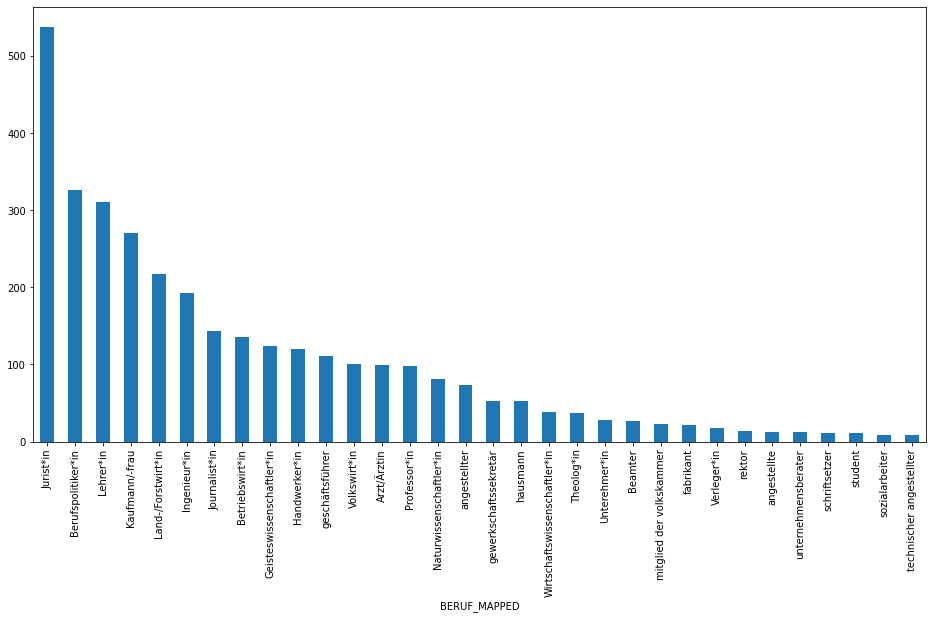

In [62]:
plt.figure(figsize=(16,8))
df_mdb.groupby('BERUF_MAPPED')['ID'].count().sort_values(ascending=False)[:32].plot(kind='bar')

In [63]:
len(set(df_mdb['BERUF_MAPPED']))

588

# construct df_mdb_wp

In [64]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 20)


In [65]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,12
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,13
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,14
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,15
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,1954-07-17,evangelisch,verh.,Berufspolitiker*in,16


# compute age

In [66]:
df_wp_startdaten = pd.read_csv('data/wp_startdaten.csv', index_col=0)
df_wp_startdaten

,START_DATE
1,1949-09-07
2,1953-10-06
3,1957-10-15
4,1961-10-17
5,1965-10-19
6,1969-10-20
7,1972-12-13
8,1976-12-14
9,1980-11-04
10,1983-03-29


In [67]:
df_wp_startdaten['START_DATE'] = pd.to_datetime(df_wp_startdaten['START_DATE'])

In [68]:
df_mdb_wp = df_mdb_wp.join(df_wp_startdaten, on='WP')

In [69]:
df_mdb_wp['START_DATE'] = pd.to_datetime(df_mdb_wp['START_DATE'])
df_mdb_wp['GEBURTSDATUM'] = pd.to_datetime(df_mdb_wp['GEBURTSDATUM'])

In [70]:
def match_age(x):
    if x < 30:
        return ('< 30')
    elif x < 40:
        return('30 - 40')
    elif x < 50:
        return('40 - 50')
    elif x < 60:
        return('50 - 60')
    elif x < 70:
        return('70 - 80')
    else:
        return('>= 80')

In [71]:
match_age(80)

'>= 80'

In [72]:
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_DATE'] - df_mdb_wp['GEBURTSDATUM']
df_mdb_wp['START_AGE_IN_YEARS'] = df_mdb_wp['START_AGE_IN_YEARS']/np.timedelta64(1,'Y')

df_mdb_wp

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,GEBURSDATUM_DATE,RELIGION_MAPPED,FAMILIENSTAND_MAPPED,BERUF_MAPPED,WP,START_DATE,START_AGE_IN_YEARS
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,5,1965-10-19,34.998665
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,6,1969-10-20,39.001485
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,7,1972-12-13,42.150078
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,8,1976-12-14,46.152898
0,11000001,Abelein,Manfred,1930-10-20,Stuttgart,UNBEKANNT,17.01.2008,männlich,keine Angaben,katholisch,...,None,None,7,1930-10-20,katholisch,keine Angaben,Jurist*in,9,1980-11-04,50.043464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,11004958,Nölke,Matthias,1980-08-01,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,"Mitgl. des Landesvorstands der FDP Hessen, Vor...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1980-08-01,konfessionslos,ledig,Jurist*in,19,2017-10-24,37.230059
4085,11004959,Martin,Dorothee,1978-01-21,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,1997 Abitur. Studium Politikwissenschaft und S...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,1,1978-01-21,UNBEKANNT,UNBEKANNT,selbstständige kommunikationsberater,19,2017-10-24,39.757148
4086,11004960,Wetzel,Wolfgang,1968-11-05,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,Abschluss 10. Klasse POS. Ausbildung zum Krank...,None,1,1968-11-05,katholisch,"verh., 2 Kinder",Lehrer*in,19,2017-10-24,48.967467
4087,11004961,Natterer,Christian,1981-02-19,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,1992/98 Mittlere Reife am Bildungszentrum Bodn...,None,1,1981-02-19,katholisch,"verh., 1 Kind",Kaufmann/-frau,19,2017-10-24,36.677002


<AxesSubplot:>

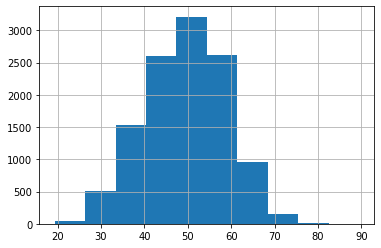

In [73]:
df_mdb_wp['START_AGE_IN_YEARS'].hist()

<AxesSubplot:>

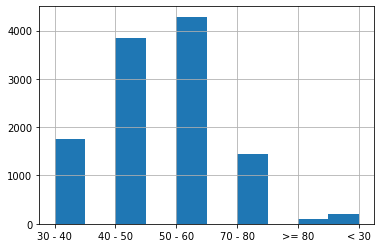

In [74]:
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'] = df_mdb_wp['START_AGE_IN_YEARS'].apply(lambda x: match_age(x)) 
df_mdb_wp['START_AGE_IN_YEARS_MAPPED'].hist()

In [75]:
list_of_altersklassen = sorted(list(set(df_mdb_wp['START_AGE_IN_YEARS_MAPPED'])))
list_of_altersklassen = ['< 30', '30 - 40', '40 - 50', '50 - 60', '70 - 80',  '>= 80']
list_of_altersklassen

['< 30', '30 - 40', '40 - 50', '50 - 60', '70 - 80', '>= 80']

# Jahre im Amt

In [76]:
df_mdb_wp = df_mdb_wp.join(df_mdb_wp[['ID', 'START_DATE']].groupby('ID').min(), how='left', rsuffix='_FIRST', on='ID')

In [77]:
df_mdb_wp['NUM_YEARS_IN_BT'] = df_mdb_wp['START_DATE'] - df_mdb_wp['START_DATE_FIRST']
df_mdb_wp['NUM_YEARS_IN_BT'] = df_mdb_wp['NUM_YEARS_IN_BT']/np.timedelta64(1,'Y')

In [78]:
df_mdb_wp.shape

(11627, 25)

In [79]:
df_mdb_wp.columns

Index(['ID', 'NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT',
       'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION',
       'BERUF', 'PARTEI_KURZ', 'VITA_KURZ', 'VEROEFFENTLICHUNGSPFLICHTIGES',
       'ANZ_WAHLPERIODEN', 'GEBURSDATUM_DATE', 'RELIGION_MAPPED',
       'FAMILIENSTAND_MAPPED', 'BERUF_MAPPED', 'WP', 'START_DATE',
       'START_AGE_IN_YEARS', 'START_AGE_IN_YEARS_MAPPED', 'START_DATE_FIRST',
       'NUM_YEARS_IN_BT'],
      dtype='object')

In [92]:
# delemte
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= 1) & (df_mdb_wp['WP']<= 19)]
#selected_df = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parteien)]
grouped = selected_df[['ID', 'START_DATE', 'NUM_YEARS_IN_BT', 'PARTEI_KURZ']].groupby(['START_DATE', 'PARTEI_KURZ']).mean()

In [95]:
grouped.reset_index(inplace=True)

<AxesSubplot:>

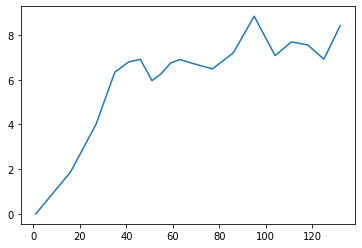

In [96]:
# delemte
grouped[grouped['PARTEI_KURZ']=='CDU']['NUM_YEARS_IN_BT'].plot()

In [103]:
from src.config import LIST_OF_COLORS

In [217]:
import plotly.graph_objects as go
import plotly.express as px

selected_parties=['SPD', 'CDU', 'FDP', 'CSU']
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= 1) & (df_mdb_wp['WP']<= 19)]
selected_df = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parties)]
grouped = selected_df[['ID', 'START_DATE', 'NUM_YEARS_IN_BT', 'PARTEI_KURZ']].groupby(['START_DATE', 'PARTEI_KURZ']).mean()
#grouped.reset_index(inplace=True)
grouped.head()

NUM_YEARS_IN_BT
START_DATE PARTEI_KURZ                 
1949-09-07 CDU                 0.000000
           CSU                 0.000000
           FDP                 0.000000
           SPD                 0.000000
1953-10-06 CDU                 1.881485

In [218]:
#new_index = pd.MultiIndex.from_product([selected_parties, sorted(set(grouped.reset_index()['WP']))], names=['PARTEI_KURZ', 'WP'])
new_index = pd.MultiIndex.from_product([grouped.index.levels[0], grouped.index.levels[1]], names=['START_DATE', 'PARTEI_KURZ'])
new_index#

MultiIndex([('1949-09-07', 'CDU'),
            ('1949-09-07', 'CSU'),
            ('1949-09-07', 'FDP'),
            ('1949-09-07', 'SPD'),
            ('1953-10-06', 'CDU'),
            ('1953-10-06', 'CSU'),
            ('1953-10-06', 'FDP'),
            ('1953-10-06', 'SPD'),
            ('1957-10-15', 'CDU'),
            ('1957-10-15', 'CSU'),
            ('1957-10-15', 'FDP'),
            ('1957-10-15', 'SPD'),
            ('1961-10-17', 'CDU'),
            ('1961-10-17', 'CSU'),
            ('1961-10-17', 'FDP'),
            ('1961-10-17', 'SPD'),
            ('1965-10-19', 'CDU'),
            ('1965-10-19', 'CSU'),
            ('1965-10-19', 'FDP'),
            ('1965-10-19', 'SPD'),
            ('1969-10-20', 'CDU'),
            ('1969-10-20', 'CSU'),
            ('1969-10-20', 'FDP'),
            ('1969-10-20', 'SPD'),
            ('1972-12-13', 'CDU'),
            ('1972-12-13', 'CSU'),
            ('1972-12-13', 'FDP'),
            ('1972-12-13', 'SPD'),
            ('1976-1

In [232]:
    # create entries also for 0 values
grouped_reindexed = grouped.reindex(new_index, fill_value=0)
grouped_reindexed.head(12)

NUM_YEARS_IN_BT
START_DATE PARTEI_KURZ                 
1949-09-07 CDU                 0.000000
           CSU                 0.000000
           FDP                 0.000000
           SPD                 0.000000
1953-10-06 CDU                 1.881485
           CSU                 1.311262
           FDP                 2.540054
           SPD                 2.373936
1957-10-15 CDU                 4.026812
           CSU                 3.828821
           FDP                 2.966066
           SPD                 4.531236

In [233]:
# double deleteme
df_mdb_wp.sort_values(by='NUM_YEARS_IN_BT')[['NACHNAME', 'VORNAME', 'PARTEI_KURZ', 'WP', 'NUM_YEARS_IN_BT']].tail()

,NACHNAME,VORNAME,PARTEI_KURZ,WP,NUM_YEARS_IN_BT
2265,Stücklen,Richard,CSU,11,37.449092
2254,Strauß,Franz Josef,CSU,11,37.449092
1924,Schäuble,Wolfgang,CDU,18,40.857786
241,Brandt,Willy,SPD,12,41.284900
1924,Schäuble,Wolfgang,CDU,19,44.863344


In [234]:
df_mdb_wp[df_mdb_wp.PARTEI_KURZ=='FDP'].sort_values(by='NUM_YEARS_IN_BT')[['NACHNAME', 'VORNAME', 'PARTEI_KURZ', 'WP', 'NUM_YEARS_IN_BT']].tail()

,NACHNAME,VORNAME,PARTEI_KURZ,WP,NUM_YEARS_IN_BT
654,Genscher,Hans-Dietrich,FDP,13,29.060145
1499,Mischnick,Wolfgang,FDP,11,29.344887
1507,Möllemann,Jürgen W.,FDP,15,29.843186
1499,Mischnick,Wolfgang,FDP,12,33.180695
2175,Solms,Hermann Otto,FDP,19,36.969958


In [235]:
grouped_reindexed.reset_index(inplace=True)

In [226]:
# make it orderable
grouped_reindexed['PARTEI_KURZ'] = pd.Categorical(grouped_reindexed['PARTEI_KURZ'], selected_parties)

In [236]:
grouped_reindexed.sort_values(by=['START_DATE', 'PARTEI_KURZ'], inplace=True)

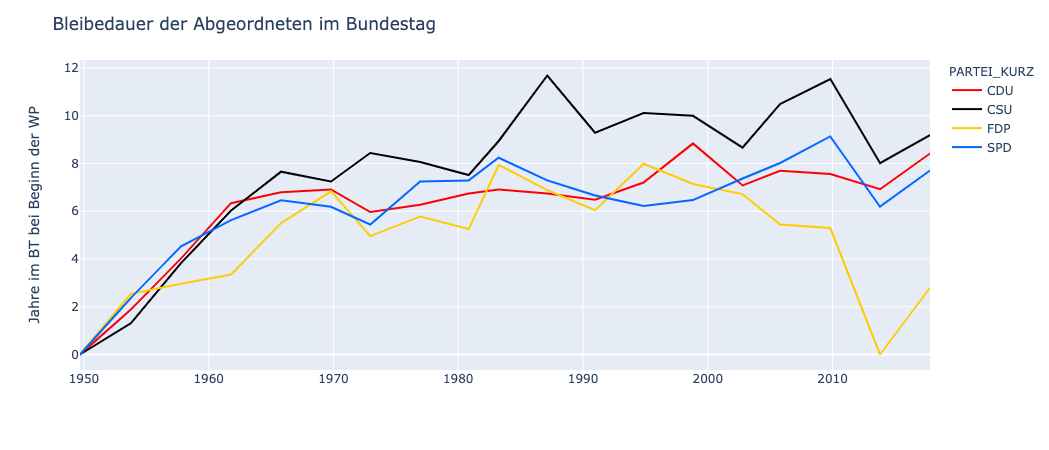

In [237]:
#fig = px.scatter(x=grouped['NUM_YEARS_IN_BT'].index, y= grouped['NUM_YEARS_IN_BT'])
fig = go.Figure(data=px.line(grouped_reindexed, x='START_DATE', y= 'NUM_YEARS_IN_BT', 
                                color='PARTEI_KURZ', color_discrete_sequence = LIST_OF_COLORS))
fig.update_layout(title='Bleibedauer der Abgeordneten im Bundestag',
               xaxis_title='',
               yaxis_title='Jahre im BT bei Beginn der WP')
fig.show()

In [210]:
a

NameError: name 'a' is not defined

In [ ]:
# end deleteme

# save as csv

In [ ]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [ ]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [ ]:
df_mdb.columns

In [ ]:
df_mdb.tail()

In [ ]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

# quality checks

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]